In [34]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt 
import math

from functools import lru_cache
from statsmodels.stats.proportion import proportion_confint
from tqdm import tqdm, trange

In [41]:
DISTROS = {
    'Norm': sps.norm(loc=0, scale=1),
    'Uniform': sps.uniform(loc=-1, scale=1),
    'Exp': sps.expon(scale=2),
    'Log': sps.logistic(loc=1, scale=1),
    'Laplace': sps.laplace(loc=2, scale=1),
    'Cauchy': sps.cauchy(loc=1, scale=1)
}
N = 10 ** 3
SAMPLE_SIZES = np.array([10, 50, 100, 150, 200, 500])
FRR = 0.05

In [36]:
for d in DISTROS:
    print(f"{d}: E[r] = {DISTROS[d].stats('m')}, Var[r] = {DISTROS[d].stats('v'):.5f}, STD = {math.sqrt(DISTROS[d].stats('v')):.3f}")

Norm: E[r] = 0.0, Var[r] = 1.00000, STD = 1.000
Uniform: E[r] = -0.5, Var[r] = 0.08333, STD = 0.289
Exp: E[r] = 2.0, Var[r] = 4.00000, STD = 2.000
Log: E[r] = 1.0, Var[r] = 3.28987, STD = 1.814
Laplace: E[r] = 2.0, Var[r] = 2.00000, STD = 1.414
Cauchy: E[r] = nan, Var[r] = nan, STD = nan


In [37]:
shapiro_actual_frr = []
shapiro_errors_frr = []
shapiro_actual_far = {d: [] for d in DISTROS}
shapiro_errors_far = {d: [] for d in DISTROS}
francia_actual_frr = []
francia_errors_frr = []
francia_actual_far = {d: [] for d in DISTROS}
francia_errors_far = {d: [] for d in DISTROS}
for n in tqdm(SAMPLE_SIZES):
    for d_name, distribution in DISTROS.items():
        if d_name == 'Norm':
            shapiro_false_rejections = 0
            francia_false_rejections = 0
        else:
            shapiro_false_acceptances = 0
            francia_false_acceptances = 0
        for _ in range(N):
            sample = distribution.rvs(n)
            _, shapiro_p_value = sps.shapiro(sample)
            _, francia_p_value = sps.normaltest(sample)
            if d_name == 'Norm':
                if shapiro_p_value < FRR:
                    shapiro_false_rejections += 1
                if francia_p_value < FRR:
                    francia_false_rejections += 1
            else:
                if shapiro_p_value > FRR:
                    shapiro_false_acceptances += 1
                if francia_p_value > FRR:
                    francia_false_acceptances += 1
        if d_name == 'Norm':
            shapiro_cur_frr = shapiro_false_rejections / N
            shapiro_actual_frr.append(shapiro_cur_frr)
            shapiro_cur_frr_low, shapiro_cur_frr_high = proportion_confint(shapiro_false_rejections, N)
            shapiro_errors_frr.append([shapiro_cur_frr - shapiro_cur_frr_low, shapiro_cur_frr_high - shapiro_cur_frr])

            francia_cur_frr = francia_false_rejections / N
            francia_actual_frr.append(francia_cur_frr)
            francia_cur_frr_low, francia_cur_frr_high = proportion_confint(francia_false_rejections, N)
            francia_errors_frr.append([francia_cur_frr - francia_cur_frr_low, francia_cur_frr_high - francia_cur_frr])
        else:
            shapiro_cur_far = shapiro_false_acceptances / N
            shapiro_actual_far[d_name].append(shapiro_cur_far)
            shapiro_cur_far_low, shapiro_cur_far_high = proportion_confint(shapiro_false_acceptances, N)
            shapiro_errors_far[d_name].append([shapiro_cur_far - shapiro_cur_far_low, shapiro_cur_far_high - shapiro_cur_far])

            francia_cur_far = francia_false_acceptances / N
            francia_actual_far[d_name].append(francia_cur_far)
            francia_cur_far_low, francia_cur_far_high = proportion_confint(francia_false_acceptances, N)
            francia_errors_far[d_name].append([francia_cur_far - francia_cur_far_low, francia_cur_far_high - francia_cur_far])

  0%|          | 0/6 [00:00<?, ?it/s]

/mnt/d/Homework/5_semester/МПС/hse-applied-statistics-methods/venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
100%|██████████| 6/6 [00:52<00:00,  8.69s/it]


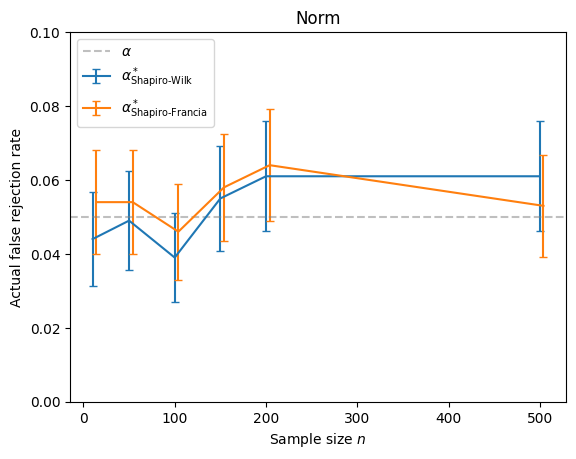

In [45]:
plt.errorbar(SAMPLE_SIZES, shapiro_actual_frr, np.transpose(shapiro_errors_frr), capsize=3, label='$\\alpha^*_{\\text{Shapiro-Wilk}}$')
plt.errorbar(SAMPLE_SIZES+4, francia_actual_frr, np.transpose(francia_errors_frr), capsize=3, label='$\\alpha^*_{\\text{Shapiro-Francia}}$')
plt.axhline(FRR, linestyle='--', color='gray', alpha=0.5, label='$\\alpha$')
plt.ylabel('Actual false rejection rate')
plt.xlabel('Sample size $n$')
plt.title("Norm")
plt.ylim(0, 0.1)
plt.legend()
plt.show()

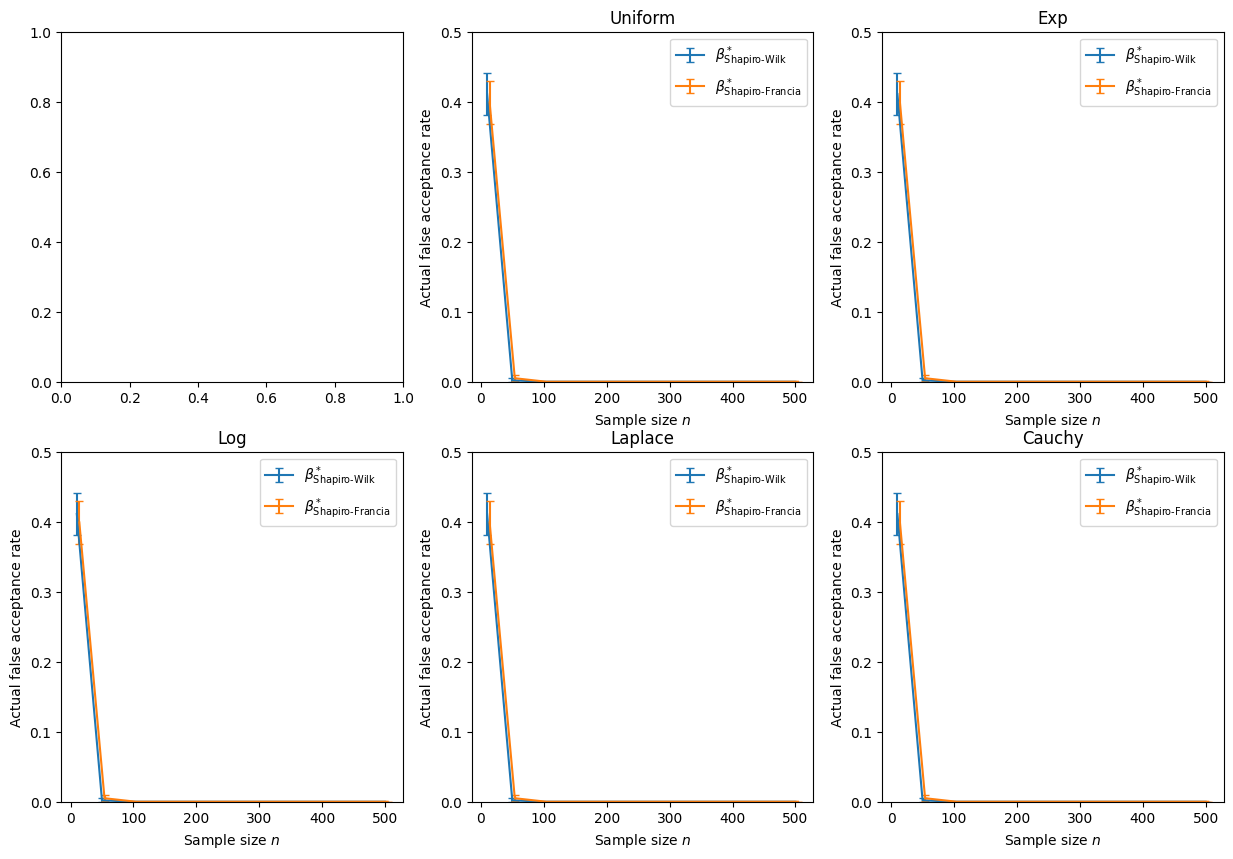

In [48]:
_, axes = plt.subplots(2, 3, figsize=(15, 10))
for d_id, d_name in enumerate(DISTROS.keys()):
    if d_name == 'Norm':
        continue
    ax: plt.Axes = axes[d_id // 3][d_id % 3]
    ax.errorbar(SAMPLE_SIZES, shapiro_actual_far[d], np.transpose(shapiro_errors_far[d]), capsize=3, label='$\\beta^*_{\\text{Shapiro-Wilk}}$')
    ax.errorbar(SAMPLE_SIZES+4, francia_actual_far[d], np.transpose(francia_errors_far[d]), capsize=3, label='$\\beta^*_{\\text{Shapiro-Francia}}$')
    # plt.axhline(FAR, linestyle='--', color='gray', alpha=0.5, label='$\\beta$')
    ax.set_ylabel('Actual false acceptance rate')
    ax.set_xlabel('Sample size $n$')
    ax.title.set_text(d_name)
    ax.set_ylim(0, 0.5)
    ax.legend()
plt.show()

In [ ]:
DS = np.linspace(0.1, 1, num=10)

In [51]:
shapiro_actual_frr = {d_id: [] for d_id, _ in enumerate(DS)}
shapiro_errors_frr = {d_id: [] for d_id, _ in enumerate(DS)}
francia_actual_frr = {d_id: [] for d_id, _ in enumerate(DS)}
francia_errors_frr = {d_id: [] for d_id, _ in enumerate(DS)}
for d_id, d in enumerate(tqdm(DS)):
    for n in SAMPLE_SIZES:
        shapiro_false_rejections = 0
        francia_false_rejections = 0
        for _ in range(N):
            sample = DISTROS['Norm'].rvs(n)
            _, shapiro_p_value = sps.shapiro(sample)
            _, francia_p_value = sps.normaltest(sample)
            if shapiro_p_value < FRR:
                shapiro_false_rejections += 1
            if francia_p_value < FRR:
                francia_false_rejections += 1
        shapiro_cur_frr = shapiro_false_rejections / N
        shapiro_actual_frr[d_id].append(shapiro_cur_frr)
        shapiro_cur_frr_low, shapiro_cur_frr_high = proportion_confint(shapiro_false_rejections, N)
        shapiro_errors_frr[d_id].append([shapiro_cur_frr - shapiro_cur_frr_low, shapiro_cur_frr_high - shapiro_cur_frr])

        francia_cur_frr = francia_false_rejections / N
        francia_actual_frr[d_id].append(francia_cur_frr)
        francia_cur_frr_low, francia_cur_frr_high = proportion_confint(francia_false_rejections, N)
        francia_errors_frr[d_id].append([francia_cur_frr - francia_cur_frr_low, francia_cur_frr_high - francia_cur_frr])

100%|██████████| 10/10 [01:18<00:00,  7.82s/it]


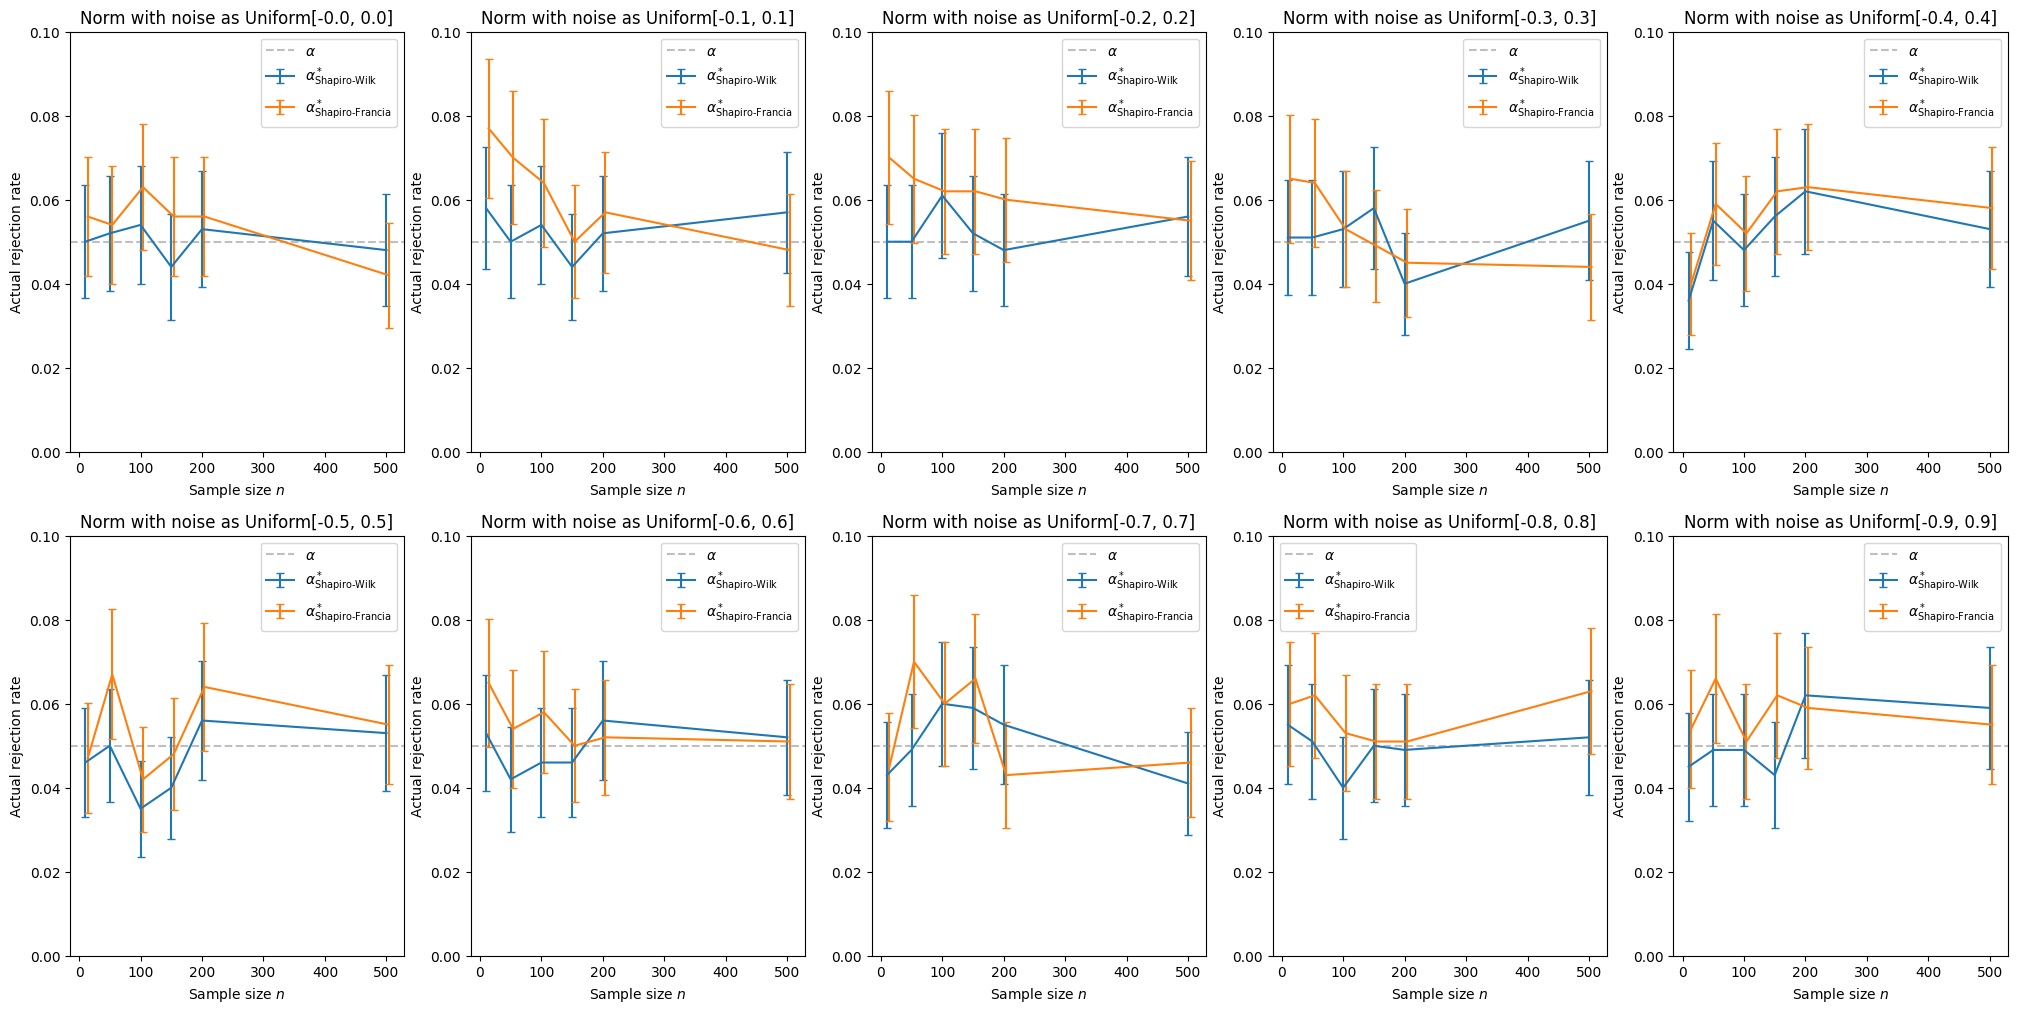

In [53]:
_, axes = plt.subplots(2, 5, figsize=(25, 12))
for d_id, d in enumerate(DS):
    ax: plt.Axes = axes[d_id // 5][d_id % 5]
    ax.errorbar(SAMPLE_SIZES, shapiro_actual_frr[d_id], np.transpose(shapiro_errors_frr[d_id]), capsize=3, label='$\\alpha^*_{\\text{Shapiro-Wilk}}$')
    ax.errorbar(SAMPLE_SIZES+4, francia_actual_frr[d_id], np.transpose(francia_errors_frr[d_id]), capsize=3, label='$\\alpha^*_{\\text{Shapiro-Francia}}$')
    ax.axhline(FRR, linestyle='--', color='gray', alpha=0.5, label='$\\alpha$')
    ax.set_ylabel('Actual rejection rate')
    ax.set_xlabel('Sample size $n$')
    ax.title.set_text(f'Norm with noise as Uniform[-{d:.1f}, {d:.1f}]')
    ax.set_ylim(0, 0.1)
    ax.legend()
plt.show()